# Mimicing the CERES model in PyMC3

In this notebook, my goal is to mimic the CERES model using PyMC3.
I will take one shortcut and replace the piecewise linear spline regression to model the effect of copy number with just a single covariate and scale the copy number.

In [3]:
import re
import string
import warnings
from pathlib import Path
from time import time
from typing import Dict, List, Optional, Tuple

import arviz as az
import ceres_models
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_analysis as pmanalysis
import pymc3_helpers as pmhelp
import seaborn as sns
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 1146
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = pmhelp.default_cache_dir

FORCE_SAMPLING = False

## Data preparation

In [4]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = dphelp.read_achilles_data(data_path)

## Modeling

### CERES Model 1

This is a non-pooling model written as originally described.

In [5]:
sgrna_idx, num_sgrnas = dphelp.get_indices_and_count(data, "sgrna")
gene_idx, num_genes = dphelp.get_indices_and_count(data, "hugo_symbol")
cell_idx, num_cells = dphelp.get_indices_and_count(data, "depmap_id")

In [7]:
ceres_m1 = ceres_models.construct_ceres_m1(
    sgrna_idx=sgrna_idx,
    gene_idx=gene_idx,
    cell_idx=cell_idx,
    cn_data=data.z_log2_cn.to_numpy(),
    lfc_data=data.lfc.to_numpy(),
)

ceres_m1_sampling_results = pmhelp.read_cached_sampling(
    pymc3_cache_dir / "mimic-ceres-m1", model=ceres_m1
)

ceres_m1_az = pmhelp.samples_to_arviz(model=ceres_m1, res=ceres_m1_sampling_results)

Loading cached trace and posterior sample...


posterior predictive variable D's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


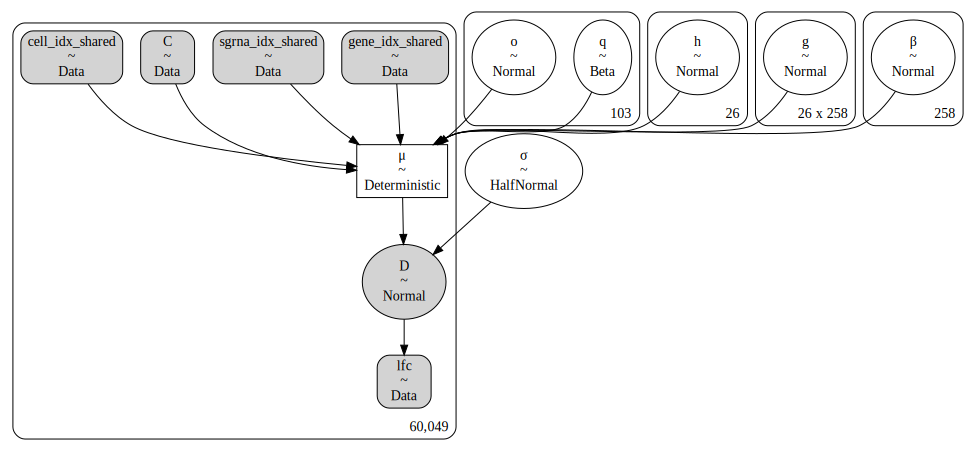

In [8]:
pm.model_to_graphviz(ceres_m1)

In [9]:
h_post_summary = az.summary(ceres_m1_az, hdi_prob=0.89, var_names="h")
h_post_summary[["hugo_symbol"]] = data.hugo_symbol.values.categories
h_post_summary.head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,hugo_symbol
h[0],-0.606,2.136,-4.511,2.526,1.184,0.926,3.0,3.0,3.0,58.0,1.71,ADAMTS13
h[1],0.554,1.504,-1.364,3.040,0.504,0.369,9.0,9.0,10.0,67.0,1.17,BRAF
h[2],-1.322,1.840,-4.579,1.273,0.824,0.620,5.0,5.0,5.0,50.0,1.36,CXCL2
h[3],-0.067,1.867,-2.303,3.454,0.376,0.269,25.0,25.0,24.0,33.0,1.08,DISP1
h[4],0.364,1.881,-2.568,3.297,0.367,0.262,26.0,26.0,27.0,28.0,1.01,DPH7


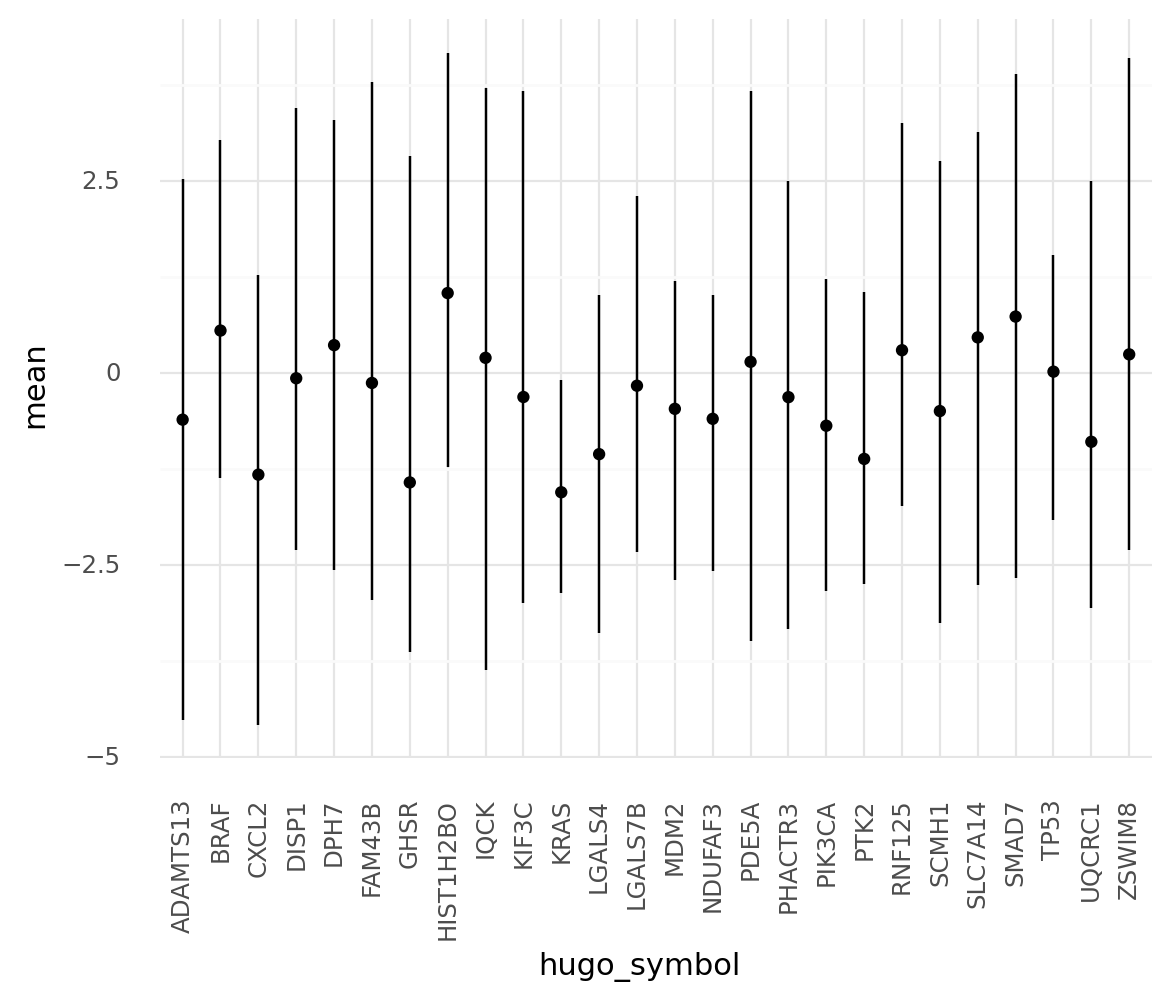

<ggplot: (8773829100270)>

In [10]:
(
    gg.ggplot(h_post_summary, gg.aes(x="hugo_symbol", y="mean"))
    + gg.geom_point()
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"))
    + gg.theme(axis_text_x=gg.element_text(angle=90))
)

In [11]:
g_post_summary = (
    az.summary(ceres_m1_az, hdi_prob=0.89, var_names="g", kind="stats")
    .reset_index(drop=False)
    .rename(columns={"index": "g_kj"})
)

g_post_summary = pmanalysis.extract_matrix_variable_indices(
    g_post_summary,
    col="g_kj",
    idx1=data.hugo_symbol.values.categories,
    idx2=data.depmap_id.values.categories,
    idx1name="hugo_symbol",
    idx2name="depmap_id",
)

g_post_summary.head()

,g_kj,mean,sd,hdi_5.5%,hdi_94.5%,hugo_symbol,depmap_id
0,"g[0,0]",-0.030,1.182,-2.191,1.532,ADAMTS13,ACH-000025
1,"g[0,1]",0.410,1.454,-1.869,2.580,ADAMTS13,ACH-000036
2,"g[0,2]",0.682,1.146,-1.033,2.536,ADAMTS13,ACH-000040
3,"g[0,3]",-2.769,1.214,-4.366,-0.810,ADAMTS13,ACH-000055
4,"g[0,4]",0.318,1.298,-1.821,2.025,ADAMTS13,ACH-000067


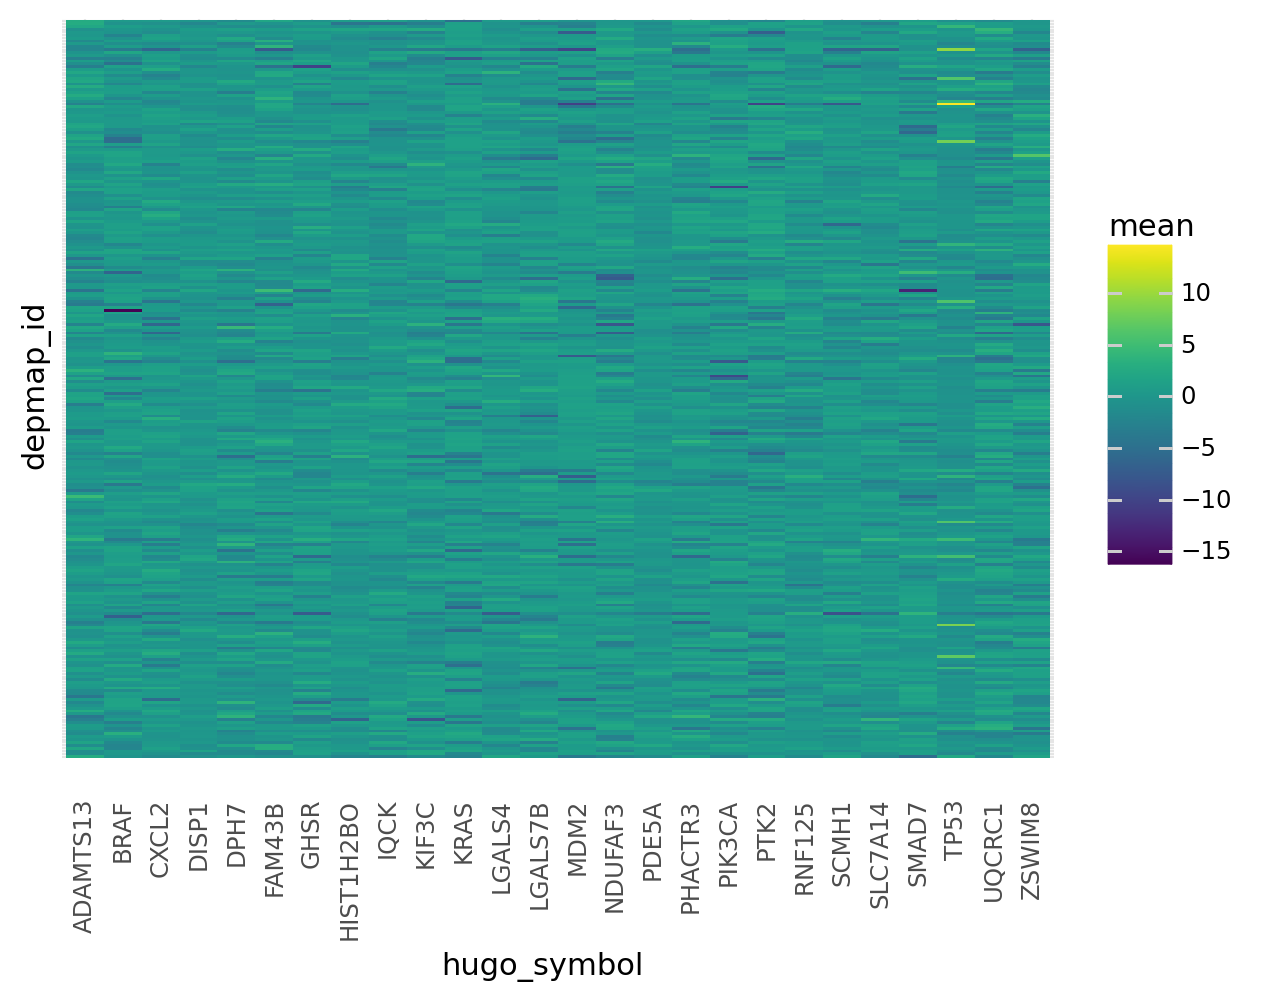

<ggplot: (8773828476790)>

In [13]:
(
    gg.ggplot(g_post_summary, gg.aes(x="hugo_symbol", y="depmap_id"))
    + gg.geom_tile(gg.aes(fill="mean"))
    + gg.theme(axis_text_x=gg.element_text(angle=90), axis_text_y=gg.element_blank())
)

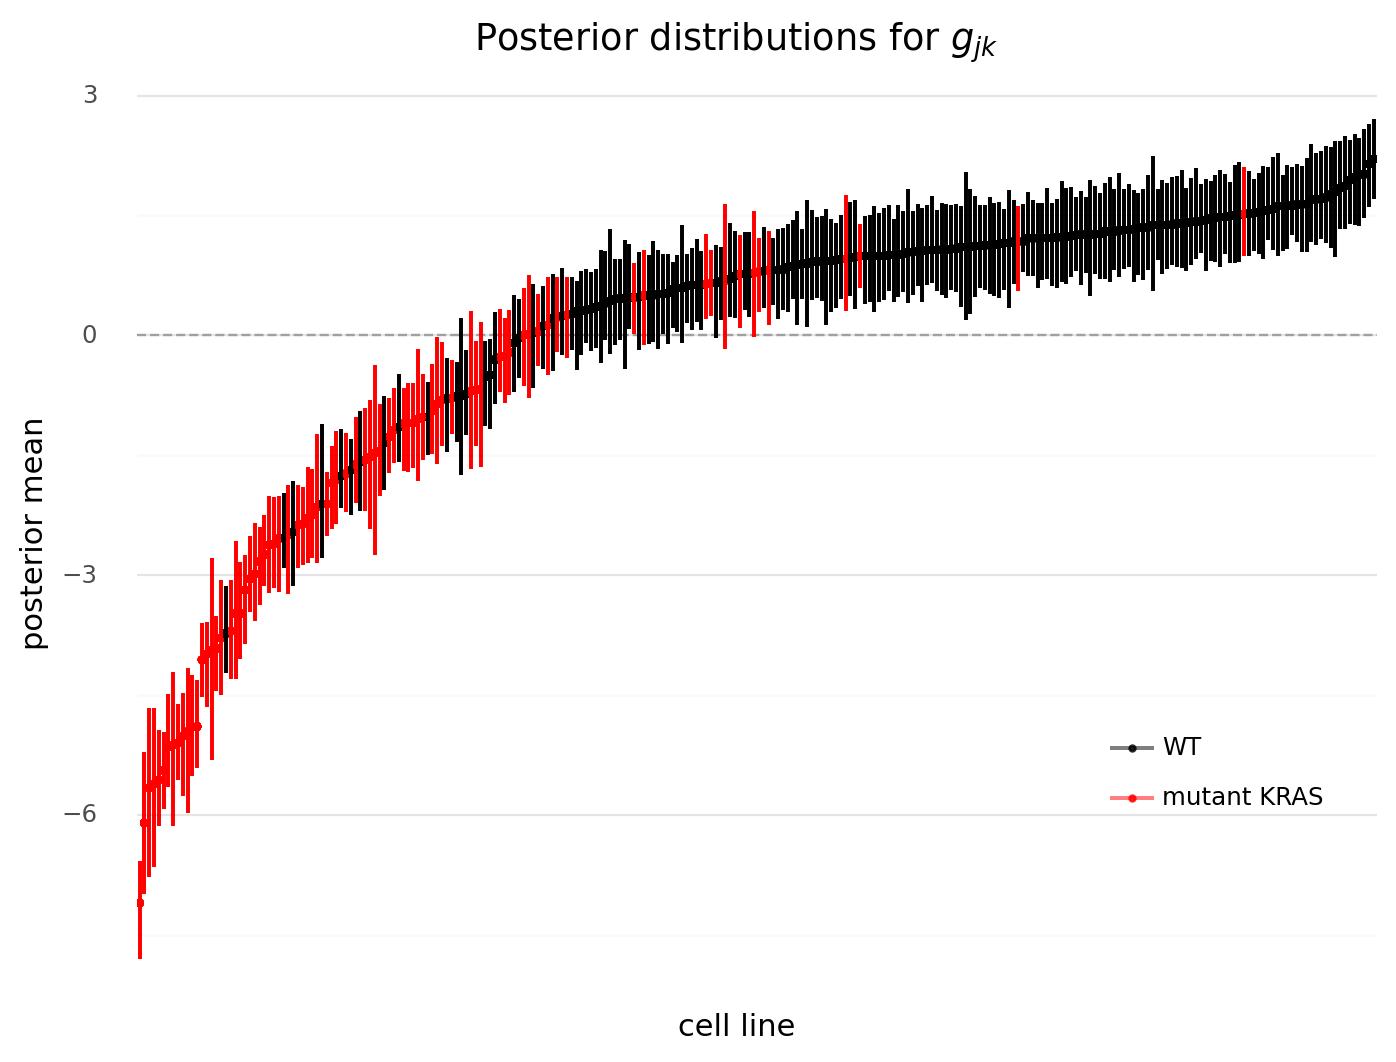

<ggplot: (8773933061139)>

In [38]:
pos = gg.position_dodge(width=0.7)

plot_data = (
    g_post_summary[g_post_summary.hugo_symbol == "KRAS"]
    .merge(data[["depmap_id", "kras_mutation"]].reset_index(drop=True), on="depmap_id")
    .assign(kras_mutation=lambda d: [x != "WT" for x in d.kras_mutation])
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(dphelp.make_cat, col="depmap_id")
)

(
    gg.ggplot(plot_data, gg.aes(x="depmap_id", color="kras_mutation"))
    + gg.geom_hline(yintercept=0, color="black", alpha=0.3, linetype="--")
    + gg.geom_point(gg.aes(y="mean"), size=0.7, alpha=0.8)
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"),
        position=pos,
        alpha=0.5,
    )
    + gg.scale_color_manual(values=("black", "red"), labels=("WT", "mutant KRAS"))
    + gg.theme(
        axis_text_x=gg.element_blank(),
        figure_size=(8, 6),
        panel_grid_major_x=gg.element_blank(),
        legend_position=(0.8, 0.3),
        legend_title=gg.element_blank(),
    )
    + gg.labs(
        x="cell line", y="posterior mean", title=r"Posterior distributions for $g_{jk}$"
    )
)

In [39]:
beta_post_summary = az.summary(ceres_m1_az, var_names="β", hdi_prob=0.89, kind="stats")
beta_post_summary[["depmap_id"]] = data.depmap_id.values.categories
beta_post_summary.head()

,mean,sd,hdi_5.5%,hdi_94.5%,depmap_id
β[0],-0.024,0.031,-0.070,0.026,ACH-000025
β[1],0.050,0.046,-0.030,0.116,ACH-000036
β[2],-0.015,0.027,-0.056,0.029,ACH-000040
β[3],-0.021,0.043,-0.093,0.041,ACH-000055
β[4],-0.016,0.046,-0.085,0.049,ACH-000067


/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


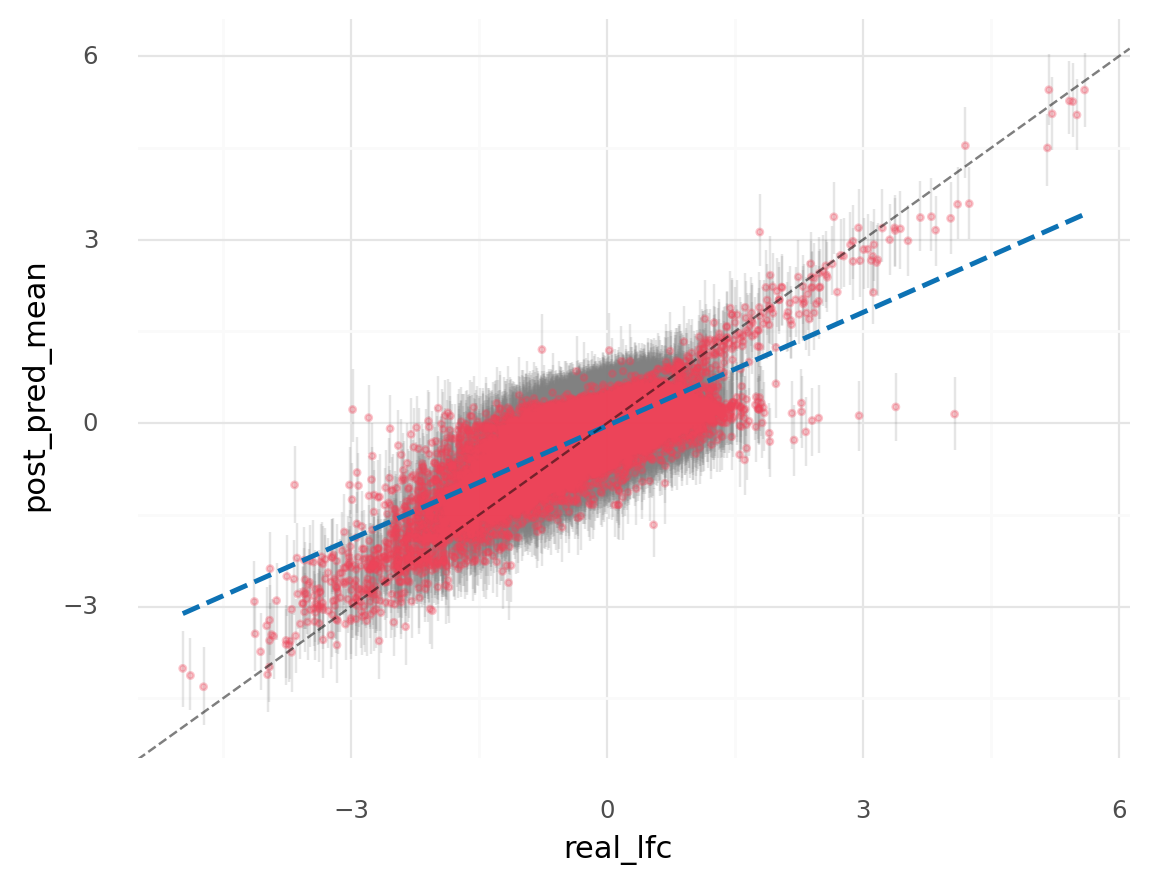

<ggplot: (8773809234080)>

In [44]:
# TODO: turn this into a function for `pymc3_analysis.py`.

m1_ppc_mean = np.mean(ceres_m1_sampling_results["posterior_predictive"]["D"], axis=0)
m1_ppc_hdi = az.hdi(
    ceres_m1_sampling_results["posterior_predictive"]["D"], hdi_prob=0.89
)

ppc_df = pd.DataFrame(
    {
        "post_pred_mean": m1_ppc_mean,
        "post_pred_hdi_5.5%": m1_ppc_hdi[:, 0],
        "post_pred_hdi_94.5%": m1_ppc_hdi[:, 1],
        "real_lfc": data.lfc,
    }
)

(
    gg.ggplot(ppc_df, gg.aes(x="real_lfc", y="post_pred_mean"))
    + gg.geom_linerange(
        gg.aes(ymin="post_pred_hdi_5.5%", ymax="post_pred_hdi_94.5%"),
        alpha=0.2,
        size=0.5,
        color="gray",
    )
    + gg.geom_point(size=0.8, alpha=0.3, color="#EF4358")
    + gg.geom_smooth(
        formula="y~x", method="lm", se=False, color="#0D72B4", alpha=0.75, linetype="--"
    )
    + gg.geom_abline(slope=1, intercept=0, color="black", linetype="--", alpha=0.5)
)

---

### CERES Model 2

This model has the same structure for the linear model, but now introduces partial pooling by adding hyper-priors to each component of the model.

In [45]:
ceres_m2 = ceres_models.construct_ceres_m2(
    sgrna_idx=sgrna_idx,
    gene_idx=gene_idx,
    cell_idx=cell_idx,
    cn_data=data.z_log2_cn.to_numpy(),
    lfc_data=data.lfc.to_numpy(),
)

ceres_m2_sampling_results = pmhelp.read_cached_sampling(
    pymc3_cache_dir / "mimic-ceres-m2", model=ceres_m2
)

ceres_m2_az = pmhelp.samples_to_arviz(model=ceres_m2, res=ceres_m2_sampling_results)

Loading cached trace and posterior sample...


posterior predictive variable D's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


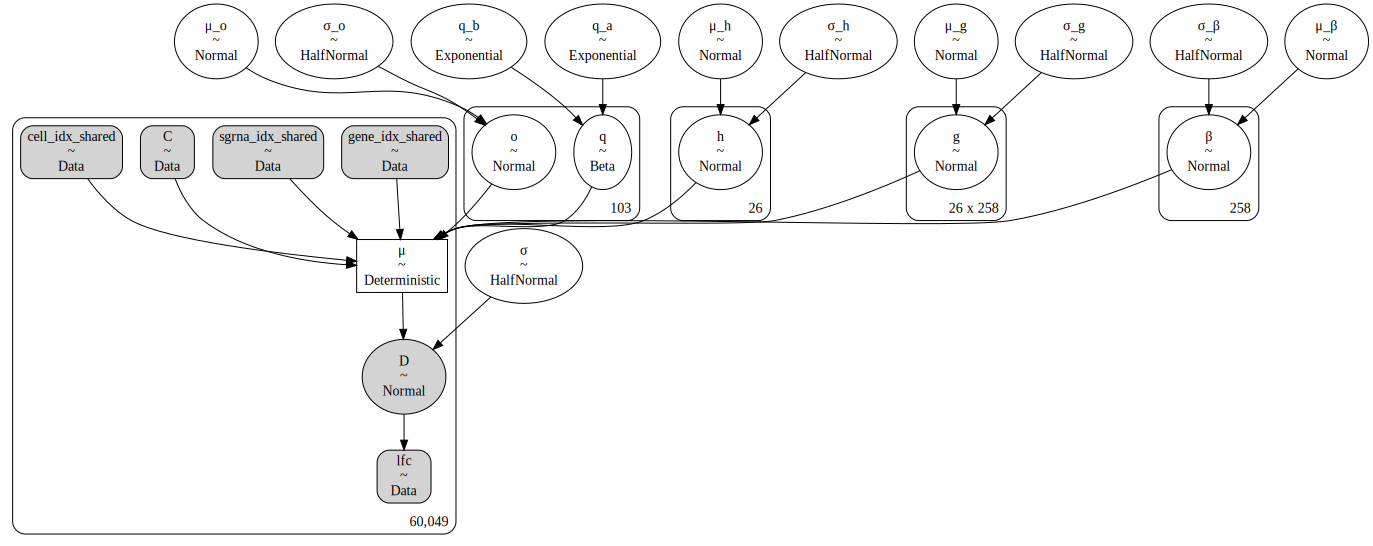

In [46]:
pm.model_to_graphviz(ceres_m2)

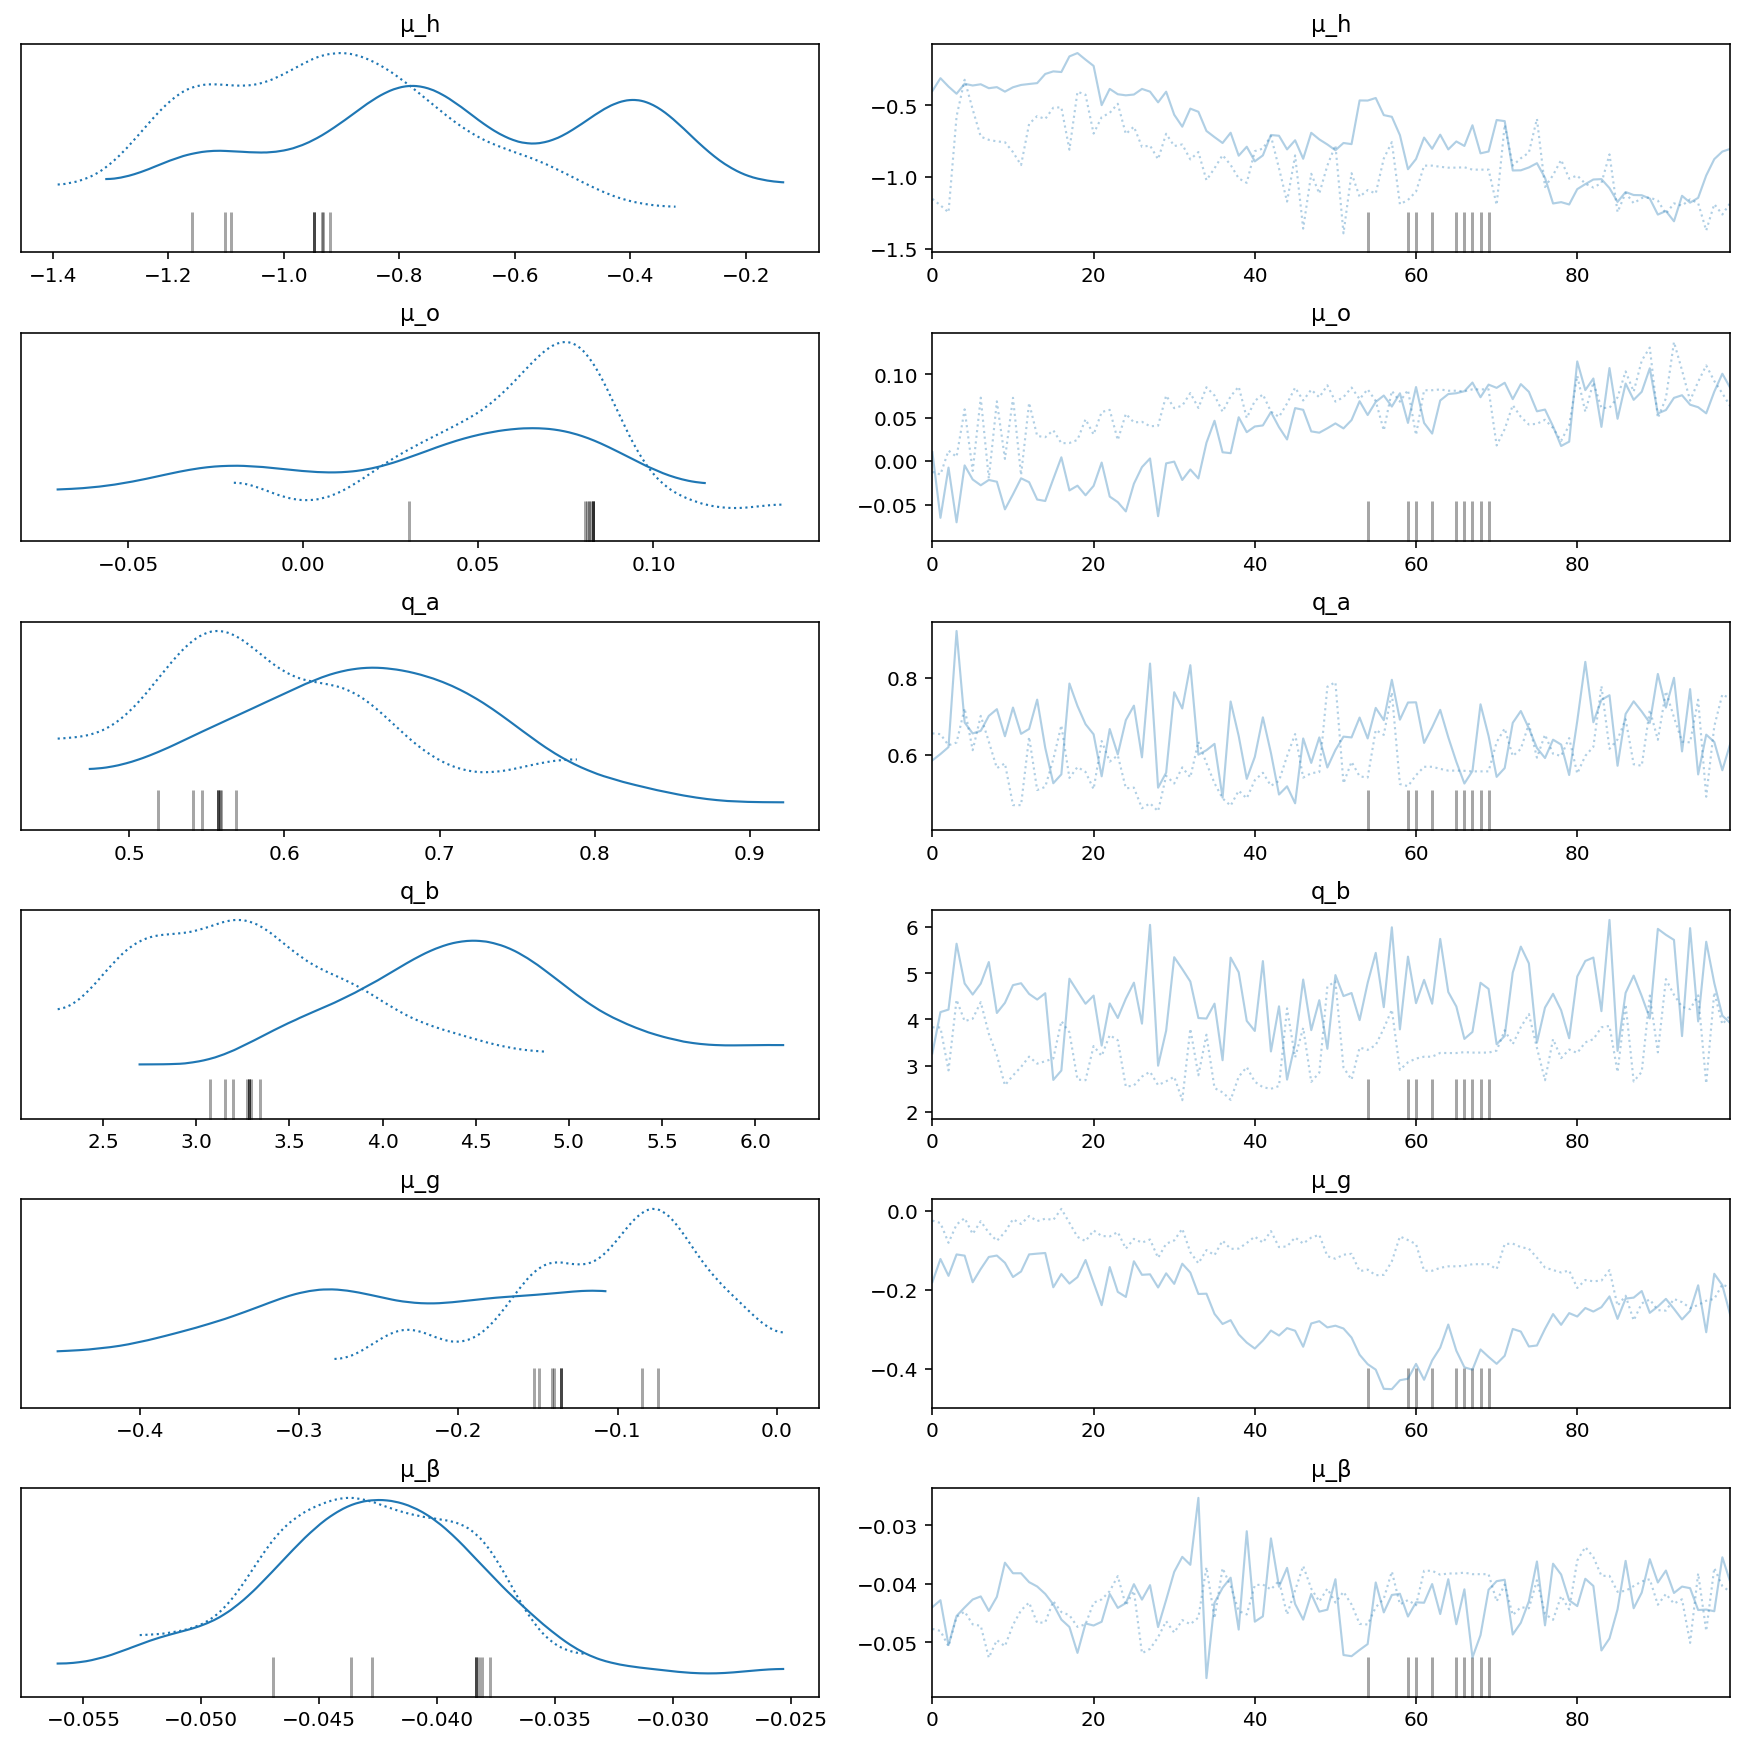

In [49]:
az.plot_trace(ceres_m2_az, var_names=["μ_h", "μ_o", "q_a", "q_b", "μ_g", "μ_β"])
plt.show()

---

In [12]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 5.81 minutes


In [13]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-02-01

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-231.o2.rc.hms.harvard.edu

Git branch: data-subset-model

numpy     : 1.19.5
plotnine  : 0.7.1
pymc3     : 3.9.3
matplotlib: 3.3.3
pandas    : 1.2.0
seaborn   : 0.11.1
theano    : 1.0.5
re        : 2.2.1
arviz     : 0.11.0

